In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from matplotlib.ticker import FormatStrFormatter
sns.set()

In [2]:
CN = ("CN",0.)
MCI = ("MCI",1.)
AD = ("AD",2.)

In [3]:
def str2date(string):
    """ Convert string to datetime object """
    return datetime.strptime(string, '%Y-%m-%d')

In [4]:
def VISCODE_conv(value):
    """Convert visit code to month int"""
    if isinstance(value, str):
        if value.startswith("m"):
            return int(value[1:])
        if value.startswith("bl"):
            return 0
        return int("NaN")

In [5]:
def PET_conv(value):
    '''Convert PET measures from string to float '''
    try:
        return float(value.strip().strip('>'))
    except ValueError:
        return float(np.nan)

In [6]:
def Diagnosis_conv(value):
    '''Convert diagnosis from string to float '''
    if value == 'CN':
        return CN
    if value == 'MCI':
        return MCI
    if value == 'AD':
        return AD
    return float('NaN')

In [7]:
def DX_conv(value):
    '''Convert change in diagnosis from string to float '''
    if isinstance(value, str):
        if value.endswith('Dementia') or value.endswith('AD'):
            return 2.
        if value.endswith('MCI'):
            return 1.
        if value.endswith('CN'):
            return 0.

    return float('NaN')

In [8]:
CONVERTERS = {
    'VISCODE':VISCODE_conv,
    'CognitiveAssessmentDate': str2date,
    'ScanDate': str2date,
    'Forecast Date': str2date,
    'EXAMDATE': str2date,
    'Diagnosis': Diagnosis_conv,
    'DX': DX_conv,
    'DX_bl':DX_conv,
    'PTAU_UPENNBIOMK9_04_19_17': PET_conv,
    'TAU_UPENNBIOMK9_04_19_17': PET_conv,
    'ABETA_UPENNBIOMK9_04_19_17': PET_conv
}

In [9]:
TYPES = {
}

In [10]:
def load_data():
    data_file = "data/TADPOLE/ADNIMERGE.csv"
    merge_data = pd.read_csv(data_file, na_values="", converters=CONVERTERS)
    return merge_data

In [11]:
def make_date_col(starts, duration):
    """
    Return a list of list of dates
    The start date of each list of dates is specified by *starts*
    """
    date_range = [relativedelta(months=i) for i in range(duration)]
    ret = []
    for start in starts:
        ret.append([start + d for d in date_range])

    return ret

In [12]:
def has_data_mask(frame):
    """
    Check whether rows has any valid value (i.e. not NaN)
    Args:
        frame: Pandas data frame
    Return:
        (ndarray): boolean mask with the same number of rows as *frame*
        True implies row has at least 1 valid value
    """
    return ~frame.isnull().apply(np.all, axis=1)

In [13]:
def get_data_dict(frame, features):
    """
    From a frame of all subjects, return a dictionary of frames
    The keys are subjects' ID
    The data frames are:
        - sorted by *Month_bl* (which are integers)
        - have empty rows dropped (empty row has no value in *features* list)
    Args:
        frame (Pandas data frame): data frame of all subjects
        features (list of string): list of features
    Return:
        (Pandas data frame): prediction frame
    """
    ret = {}
    frame_ = frame.copy()
    for subj in np.unique(frame_.RID):
        subj_data = frame_[frame_.RID == subj].sort_values('VISCODE')
        subj_data = subj_data[has_data_mask(subj_data[features])]

        #subj_data = subj_data.set_index('VISCODE', drop=True)
        ret[subj] = subj_data.drop(['RID'], axis=1)
    return ret

In [14]:
def does_transition(frame, initial_state, final_state):
    """Return how many months it takes a patient to transition from initial to final; -1 if no transition """
    """Initial and final state should be encoded as: CN = 0., MCI = 1., AD = 2."""
    transition_rows = frame.loc[(frame["DX_bl"] == initial_state) &
                                (frame["DX"] == final_state)]
    if transition_rows.empty:
        return -1
    else:
        return transition_rows["VISCODE"].iloc[0]
    

In [15]:
def transition_stats(data_dict, initial_state, final_state):
    """Return dataframe containing patients who transition from initial to final state, how long until they transitioned and their total visits"""
    transitions = 0
    transition_time = 0
    columns = ["RID", "Transition_month", "Total_months", "Transition_type"]
    data = []
    for key, value in data_dict.items():        
        t = does_transition(value, initial_state[1], final_state[1])
        if t >= 0:
            nb_visits = value["VISCODE"].iloc[value.shape[0] - 1]
            data.append([key, t, nb_visits, (initial_state[0]+" to "+final_state[0])])
    return pd.DataFrame(data, columns=columns)

In [16]:
def transition_plot(data_dict):
    transitioners_mciad = transition_stats(data_dict, MCI, AD)
    transitioners_cnmci = transition_stats(data_dict, CN, MCI)
    transitioners_cnad = transition_stats(data_dict, CN, AD)
    transitioners = pd.concat([transitioners_mciad,transitioners_cnmci,transitioners_cnad])

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=(7, 6))


    # Plot the orbital period with horizontal boxes
    sns.boxplot(x="Transition_month", y="Transition_type", data=transitioners,
                whis=[0, 100], width=.6, palette="vlag")

    # Add in points to show each observation
    sns.stripplot(x="Transition_month", y="Transition_type", data=transitioners,
                  size=4, color=".3", linewidth=0)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    plt.tight_layout()
    plt.savefig("transition_times.png")


In [17]:
merge_data = load_data()
merge_data

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,0,11,ADNI1,ADNI1,2005-09-08,0.0,74.3,Male,...,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
1,3,011_S_0003,0,11,ADNI1,ADNI1,2005-09-12,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
2,3,011_S_0003,6,11,ADNI1,ADNI1,2006-03-13,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2019-02-14 23:58:27.0
3,3,011_S_0003,12,11,ADNI1,ADNI1,2006-09-12,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12,12,2019-02-14 23:58:27.0
4,3,011_S_0003,24,11,ADNI1,ADNI1,2007-09-12,2.0,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,1.998630,23.93440,24,24,2019-02-14 23:58:27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13910,4384,029_S_4384,84,29,ADNI3,ADNI2,2019-04-09,0.0,62.3,Male,...,109.3,9.86,1.12969,NaN,1.06225,7.167690,85.83610,84,84,2019-04-10 04:36:05.0
13911,6703,135_S_6703,0,135,ADNI3,ADNI3,2019-04-09,NaN,62.7,Female,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0,0,2019-04-10 04:36:10.0
13912,6145,014_S_6145,12,14,ADNI3,ADNI3,2019-04-09,0.0,70.3,Female,...,NaN,NaN,NaN,NaN,NaN,1.073240,12.85250,12,12,2019-04-11 04:36:24.0
13913,6148,014_S_6148,12,14,ADNI3,ADNI3,2019-04-05,NaN,81.5,Female,...,NaN,NaN,NaN,NaN,NaN,1.081450,12.95080,12,12,2019-04-11 04:36:24.0


In [19]:
merge_data["index"] = merge_data.index
merge_data.groupby("DX").nunique()

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,index
DX,,,,,,,,,,,,,,,,,,,,,
0.0,869,869,16,65,4,4,1888,2,262,2,...,505,465,0,429,881,881,28,16,49,3283
1.0,1079,1079,16,66,4,4,2157,3,307,2,...,795,772,15,528,961,961,28,16,68,4374
2.0,738,738,16,64,4,4,1423,3,268,2,...,503,499,11,281,685,685,26,16,43,2216


In [29]:
features = ["DX_bl", "DX"]
data_slice = merge_data[["RID","VISCODE","DX_bl","DX"]]
data_dict = get_data_dict(data_slice, features)
    

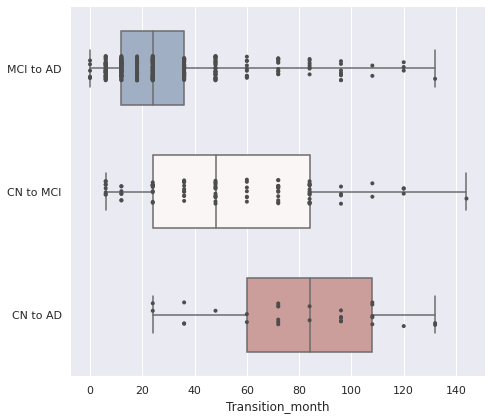

In [30]:
transition_plot(data_dict)

In [31]:
predictions = pd.read_csv("data/5_prediction.csv", index_col=0)
predictions

FileNotFoundError: [Errno 2] File data/5_prediction.csv does not exist: 'data/5_prediction.csv'

In [ ]:
pred_data_dict = get_data_dict(predictions, ["DX_pred"])



In [21]:
def round_to_two(x):
    new_x = x
    if x % 6 == 1:
        new_x -= 1
    elif x % 6 == 2:
        new_x -=2
    elif x % 6 == 5:
        new_x += 1  
    elif x % 6 == 4:
        new_x += 2
    return new_x
"""Finds matching sequences in true outcomes and prediction data dicts
Outputs a two arrays with each index containing corresponding outcomes and predictions"""
def create_comp_frame(pred:dict, true:dict):
    full_frame = []
    dx = []
    dx_pred = []
    for key, pred_val in pred.items():
        true_val = true[key]
        pred_val["VISCODE"] = pred_val["VISCODE"].apply(round_to_two)
        matched = pred_val.set_index("VISCODE").join(true_val.set_index("VISCODE"))
        full_frame.append(matched[["DX", "DX_pred"]])

    full_frame = pd.concat(full_frame, axis=0)
    full_frame.dropna(inplace=True)
    full_frame = full_frame.astype(int)
    return full_frame

In [22]:

def comp_n_clusters(start, end, n_folds):
    cluster_n = range(start, end+1)
    bac_all = []
    for i in range(start, end+1):
        bac = 0
        for j in range(n_folds):
            predictions = pd.read_csv("data/{}_{}_prediction.csv".format(i,j), index_col=0)
            pred_data_dict = get_data_dict(predictions, ["DX_pred"])
            comp = create_comp_frame(pred_data_dict, data_dict)
            bac += calc_balanced(comp.DX, comp.DX_pred)
            print(bac/(j+1))
        bac = bac/n_folds
        bac_all.append(bac)
    df = pd.DataFrame({"n_clusters":cluster_n, "bac":bac_all})
    return df
        

In [23]:
def balanced_acc_from_file(file, pred_col, true_col):
    predictions = pd.read_csv(file, index_col=0)
    pred = predictions[pred_col]
    true = predictions[true_col]
    return balanced_accuracy_score(pred, true)

In [24]:

def comp_kmeans_similarity_bac(start, end, n_folds):
    cluster_n = range(start, end+1)
    bac_all = []
    for i in cluster_n:
        bac = 0
        for j in range(n_folds):
            bac += balanced_acc_from_file("data/kmeans_similarity/{}_{}_prediction.csv".format(i,j), "DX_pred", "DX_true")
        bac = bac/n_folds
        bac_all.append(bac)
    df = pd.DataFrame({"n_clusters":cluster_n, "bac":bac_all})
    return df

In [25]:

def comp_ae_hyperparameters(lr, wd, bs, n_folds):
    bac_all = []
    for l in lr:
        for w in wd:
            for b in bs:
                directory = "data/lṛ_{}_wd_{}_bs_{}/".format(l,w,b)
                bac=0
                for j in range(n_folds):
                    bac += balanced_acc_from_file("{}{}_prediction.csv".format(directory,j), "DX_pred", "DX_true")
                bac = bac/n_folds
                store=np.array([l, w, b, bac])
                bac_all.append(store)
    all_hp = np.stack(bac_all)
    return all_hp

In [26]:
lr=[0.01, 0.005, 0.001]
wd=[0.01, 0.05, 0.1]
bs=[16,64,128]
all_hp = comp_ae_hyperparameters(lr, wd, bs, 2)
all_hp

array([[1.00000000e-02, 1.00000000e-02, 1.60000000e+01, 8.15422006e-01],
       [1.00000000e-02, 1.00000000e-02, 6.40000000e+01, 7.49909582e-01],
       [1.00000000e-02, 1.00000000e-02, 1.28000000e+02, 7.43930883e-01],
       [1.00000000e-02, 5.00000000e-02, 1.60000000e+01, 8.07555625e-01],
       [1.00000000e-02, 5.00000000e-02, 6.40000000e+01, 7.63138625e-01],
       [1.00000000e-02, 5.00000000e-02, 1.28000000e+02, 7.62074596e-01],
       [1.00000000e-02, 1.00000000e-01, 1.60000000e+01, 8.19673079e-01],
       [1.00000000e-02, 1.00000000e-01, 6.40000000e+01, 7.48287909e-01],
       [1.00000000e-02, 1.00000000e-01, 1.28000000e+02, 7.50834866e-01],
       [5.00000000e-03, 1.00000000e-02, 1.60000000e+01, 7.96859553e-01],
       [5.00000000e-03, 1.00000000e-02, 6.40000000e+01, 7.35335609e-01],
       [5.00000000e-03, 1.00000000e-02, 1.28000000e+02, 6.88151045e-01],
       [5.00000000e-03, 5.00000000e-02, 1.60000000e+01, 7.75539949e-01],
       [5.00000000e-03, 5.00000000e-02, 6.40000000e

In [27]:
bac = balanced_acc_from_file("data/2lr005.csv", "DX_pred", "DX_true")
bac

0.77651226932788

In [28]:
overlap_bacs = comp_kmeans_similarity_bac(1, 15, 10)
overlap_bacs

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTra

,n_clusters,bac
0,1,0.453829
1,2,0.648458
2,3,0.731910
3,4,0.824427
4,5,0.824673
5,6,0.827359
6,7,0.824831
7,8,0.833313
8,9,0.838435
9,10,0.840068


In [29]:
bacs = comp_kmeans_similarity_bac(1, 15, 10)
bacs

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTra

,n_clusters,bac
0,1,0.453829
1,2,0.648458
2,3,0.731910
3,4,0.824427
4,5,0.824673
5,6,0.827359
6,7,0.824831
7,8,0.833313
8,9,0.838435
9,10,0.840068


In [40]:
bacs = [0.5234, 0.654, 0.7513, 0.8082, 0.8591, 0.86543, 0.8743, 0.8790, 0.884, 0.8887, 0.8952, 0.9030, 0.9044, 0.9047, 0.9052]
n_clusters = np.arange(1,len(bacs)+1)

In [79]:
aeproloss= [0.79283949,
    0.5255684129,
0.4797132557,
0.4866129446,
0.4588807303,
0.4684660657, 
0.4534003793,
0.4559098702,
0.4306107317, 
0.4512283427, 
0.4493985133, 
0.4515803945, 
0.4459260775, 
0.4400586839, 
0.4369542697
]
aeloss= [0.73283949,
    0.6255684129,
0.5797132557,
0.5866129446,
0.588807303,
0.57684660657, 
0.5634003793,
0.5659098702,
0.5606107317, 
0.5612283427, 
0.5493985133, 
0.5515803945, 
0.5559260775, 
0.5500586839, 
0.5569542697
]

data = np.empty((2*len(aeloss)))
data[:len(aeproloss)] = aeproloss
data[len(aeproloss):] = aeloss
model = np.empty((2*len(aeloss)), dtype=object)
model[:len(aeproloss)] = "Prototypes Jointly Learned"
model[len(aeproloss):] = "Prototypes Learned from Clustering"
c = np.empty((2*len(aeloss)))
c[:len(aeproloss)] = np.arange(1,len(aeloss)+1)
c[len(aeproloss):] = np.arange(1,len(aeloss)+1)
dataframe = pd.DataFrame({"Loss":data, "Model Type":model, "Prototypes":c})
n_clusters = np.arange(1,len(aeloss)+1)
dataframe

,Loss,Model Type,Prototypes
0,0.792839,Prototypes Jointly Learned,1.0
1,0.525568,Prototypes Jointly Learned,2.0
2,0.479713,Prototypes Jointly Learned,3.0
3,0.486613,Prototypes Jointly Learned,4.0
4,0.458881,Prototypes Jointly Learned,5.0
5,0.468466,Prototypes Jointly Learned,6.0
6,0.453400,Prototypes Jointly Learned,7.0
7,0.455910,Prototypes Jointly Learned,8.0
8,0.430611,Prototypes Jointly Learned,9.0
9,0.451228,Prototypes Jointly Learned,10.0


In [110]:
dataframe = pd.read_csv("data/aeproresults.csv")


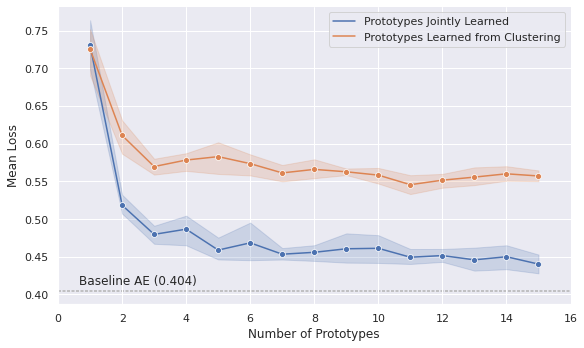

In [113]:
stats = pd.DataFrame({"Loss":loss, "Clusters":n_clusters})
stats = stats.set_index("Clusters")
ax = sns.relplot(y="AVGLOSS", x="NPROTOTYPES", kind="line", hue="Model Type", data=dataframe, marker="o");

ax.set_xticklabels(step=1)
#ax.set(ylim=(0, 1))
#plt.plot([1, 15], [0.4048969599, 0.4048969599], linewidth=1, linestyle="dashed")
label = "Baseline AE ({:.3f})".format(0.404)
plt.annotate(label, # this is the text
                 (2.5,0.400), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
ax.map(plt.axhline, y=0.4048969599, color=".7", dashes=(2, 1), zorder=0)
ax.set_ylabels("Mean Loss")
ax.set_xlabels("Number of Prototypes")
#ax._legend.set_bbox_to_anchor((0.9,.2))
plt.legend(loc='upper right')
ax._legend.remove()
plt.tight_layout()
plt.savefig("figures/prototype_ae_bac_mae.png", dpi=200)


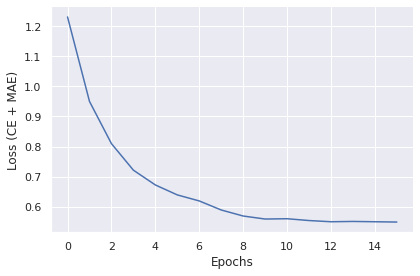

In [117]:
ce = np.array([1.23, 0.95, 0.81, 0.722, 0.673, 0.64, 0.62, 0.59, 0.57, 0.56, 0.561, 0.555, 0.551, 0.552, 0.551, 0.550])
epochs = np.arange(len(ce))
stats = pd.DataFrame({"Cross Entropy":ce, "Epochs":epochs, })
stats = stats.set_index("Epochs")
ax = sns.relplot(y="Cross Entropy", x="Epochs", kind="line", data=stats,height=4, aspect=6/4)

#ax.set_xticklabels(step=1)

ax.set_ylabels("Loss (CE + MAE)")

plt.tight_layout()
plt.savefig("figures/autoencoder_loss.png")
